#### Analysis of multiple stocks - for simulation over the course of 2 years (bi-weekly buy in)

Goal: This script simulates 2 years of bi-weekly prediction/closing_cost determinations and simulates for a series of chosen stocks if it is better to invest a consistent price or buy in higher/lower depending on the current performance of the stock.

Take any number of stocks and run a trendline through multiple 1 year cycles, creating a linear prediction to be applied bi-weekly. Assess the theoretical performance of adjusting bi-weekly contributions as compared to contributing a consistent amount every other week.


In [394]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

In [395]:
### To do's
# I really need to fix the invest days to be always on Monday or something instead of every 10 trading days
# # make the invest period dynamic - not just 10 days (2 work weeks)
# Fact check by trying different stocks entirely - do a series of poorly performing stocks, high performing stocks, and a mix
# Clean up code

### Future to do's (Once all necessary testing is finished)
# Start testing buy/sell every period based on a set budget

### Fixed
# are all ranges 1-260 or are some 0-259? - one of them was corrected, the one that sets the pred independent variable (aka index)
# test the dynamic roll_days - is it implemented everywhere it should be and everything works as expected? - seems good now
# Fix the graphs to be dynamic for dates - esp the 3 graphs stuck together - can I make the number of stuck visuals dynamic? - dropped for now
# Fix the final statement to say profit/loss or above/below dynamically
    # seems to have an issue with the reversal of percents when the total profits are negative
    # need to test with net loss stocks
# Test for different 3 year periods of time
# Fact check the dynamic dates - is everything really working?



In [396]:
##### User choices go here #####

# choose stocks of interest
# stocks chosen must all have data for full range of dates
lista = ['AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MDB', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM']
# lista = ['AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SQ', 'TSM']
# lista = ['AAPL', 'SQ', 'TSLA'] # quicker for test runs
# lista = ['TDOC', 'PINS'] # for net loss test runs

# choose how much to contribute each bi-weekly period
biwkly_contrib = 10 

# max amount to contribute per stock over the course of 2 years
# should be at least 50 times the bi-weekly contrib
invest = biwkly_contrib*50 # honestly, just leave it as is, proportional to biwkly_contrib

# number of days to roll into each linear regression. 
# 260 will be about 1 year
# 65 will be about 1 quarter
# 21 will be about 1 month
roll_days = 65

In [397]:
# Pull the closing data

data = yf.download(
        tickers = lista
        ,period = '3y'
        #,start = '2017-02-14' # to choose custom date ranges
        #,end = '2020-02-14' # to choose custom date ranges
    )

df = data['Close']
df = df.dropna() # in case the first row generates as nulls
df['Index'] = np.arange(1,len(df)+1) # add an index
df

[*********************100%***********************]  14 of 14 completed


,AAPL,AMD,AMZN,CRM,GOOG,INTC,MDB,MSFT,NVDA,QQQ,SBUX,SQ,TSLA,TSM,Index
Date,,,,,,,,,,,,,,,
2018-12-17,40.985001,18.830000,1520.910034,130.830002,1016.530029,47.080002,82.879997,102.889999,35.895000,157.429993,64.470001,58.619999,69.683998,36.220001,1
2018-12-18,41.517502,19.500000,1551.479980,132.320007,1028.709961,47.740002,84.389999,103.970001,36.735001,158.419998,64.919998,59.919998,67.405998,36.759998,2
2018-12-19,40.222500,18.160000,1495.079956,131.160004,1023.010010,45.570000,85.550003,103.690002,34.627499,154.529999,64.059998,59.029999,66.594002,36.230000,3
2018-12-20,39.207500,17.940001,1460.829956,127.730003,1009.409973,45.540001,79.769997,101.510002,33.775002,152.289993,62.150002,55.900002,63.076000,35.880001,4
2018-12-21,37.682499,16.930000,1377.449951,122.910004,979.539978,44.840000,72.949997,98.230003,32.392502,147.570007,61.389999,52.509998,63.953999,35.709999,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-09,174.559998,138.100006,3483.419922,264.320007,2962.120117,50.480000,513.280029,333.100006,304.899994,393.730011,115.349998,186.750000,1003.799988,119.500000,752
2021-12-10,179.449997,138.550003,3444.239990,266.029999,2973.500000,50.590000,507.730011,342.540009,301.980011,398.010010,116.730003,181.320007,1017.030029,119.129997,753
2021-12-13,175.740005,133.800003,3391.350098,265.760010,2934.090088,50.000000,494.929993,339.399994,281.609985,392.260010,115.559998,175.440002,966.409973,116.419998,754


In [398]:
### in progress
# setting a rolling 260 days for each observed stock

df2 = df.copy()

for j in lista:
    df2[str(j) + ' roll'] = df2[str(j)].rolling(roll_days).mean()

df2
#df2.to_csv(r'/Volumes/GoogleDrive/My Drive/Python/other_projects/roll_test.csv', index = False)

,AAPL,AMD,AMZN,CRM,GOOG,INTC,MDB,MSFT,NVDA,QQQ,...,GOOG roll,INTC roll,MDB roll,MSFT roll,NVDA roll,QQQ roll,SBUX roll,SQ roll,TSLA roll,TSM roll
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-17,40.985001,18.830000,1520.910034,130.830002,1016.530029,47.080002,82.879997,102.889999,35.895000,157.429993,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-18,41.517502,19.500000,1551.479980,132.320007,1028.709961,47.740002,84.389999,103.970001,36.735001,158.419998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-19,40.222500,18.160000,1495.079956,131.160004,1023.010010,45.570000,85.550003,103.690002,34.627499,154.529999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-20,39.207500,17.940001,1460.829956,127.730003,1009.409973,45.540001,79.769997,101.510002,33.775002,152.289993,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-21,37.682499,16.930000,1377.449951,122.910004,979.539978,44.840000,72.949997,98.230003,32.392502,147.570007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-09,174.559998,138.100006,3483.419922,264.320007,2962.120117,50.480000,513.280029,333.100006,304.899994,393.730011,...,2866.572776,51.879846,505.013693,314.912154,256.846000,380.427693,112.954770,236.479230,945.130614,116.783846
2021-12-10,179.449997,138.550003,3444.239990,266.029999,2973.500000,50.590000,507.730011,342.540009,301.980011,398.010010,...,2867.730161,51.836615,505.518308,315.608923,258.080000,380.712923,112.923077,235.398922,949.164000,116.729231
2021-12-13,175.740005,133.800003,3391.350098,265.760010,2934.090088,50.000000,494.929993,339.399994,281.609985,392.260010,...,2869.202009,51.777538,505.612616,316.281077,258.954308,380.954001,112.864923,234.284153,952.704614,116.628462


In [399]:
### in progress
# Not what I thought. I thought it would match the rolling linear predictions.
# This is a single point representing 260 days while the linear predition is a line representing 260 days
# I would have to do something weird like set a multiplier based on the gains/losses made in the last year
# but that sounds too iffy and made up

# for j in lista:
#     x = df2['Index']
#     y = df2[str(j)]
#     plt.plot(x, y)

#     x = df2['Index']
#     y = df2[str(j) + ' roll']
#     plt.plot(x, y)

#     plt.xlabel(j)
#     plt.show()

In [400]:
#df3['Dates'] = df3.index
#df3

In [401]:
### in progress
# now that I know I don't want a rolling average, find out how to more simply do a rolling linear regression
# goal is to avoid having to make 50 dataframes

# https://www.statsmodels.org/dev/examples/notebooks/generated/rolling_ls.html
# https://www.statsmodels.org/dev/generated/statsmodels.regression.rolling.RollingOLS.html

# issue - I need every iteration to have a fresh 1-260 as opposed to 1-260, then 2-261, etc
    # I can't seem to read from a stagnant list to do this

#mod = RollingOLS.from_formula("TSM ~ Index", data=df3, window=roll_days)
#rres = mod.fit()
#df3 = rres.params
#df3['TSM'] = df['TSM']
#df3['Pred'] = df3['Intercept']+(df3['Index']*roll_days)
#df3

#df3.to_csv(r'/Volumes/GoogleDrive/My Drive/Python/other_projects/roll_test.csv', index = False)

In [402]:
# function to make a useful time structure as independent variable
# def myTime(date_time_str):
#     date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S.%f')
#     return(time.mktime(date_time_obj.timetuple()))

In [403]:
#df3['Time'] = [myTime(obs) for obs in df3['Dates']]

In [404]:
# create 50 dataframes in a dictionary, each 260 days: dataframes['data0'] - dataframes['data49']
# 0 is the most recent 260 days, 49 is the oldest
# 260 days isn't exactly 1 trading year, but I think it's close enough

dataframes = {}

for j in lista:
    x = (max(df['Index']))-roll_days # roll_days sets how many rows in each df
    y = max(df['Index'])

    for i in range(50):
        dataframes['data' + str(i)] = df.iloc[x:y]
        x -= 10 # 10 denotes 2 work weeks
        y -= 10 # 10 denotes 2 work weeks

print(dataframes['data0'])
print(dataframes['data49'])

                  AAPL         AMD         AMZN         CRM         GOOG  \
Date                                                                       
2021-09-15  149.029999  105.599998  3475.790039  256.160004  2904.120117   
2021-09-16  148.789993  106.220001  3488.239990  260.359985  2887.469971   
2021-09-17  146.059998  103.879997  3462.520020  260.529999  2829.270020   
2021-09-20  142.940002  101.550003  3355.729980  258.220001  2780.340088   
2021-09-21  143.429993  102.820000  3343.629883  257.970001  2792.929932   
...                ...         ...          ...         ...          ...   
2021-12-09  174.559998  138.100006  3483.419922  264.320007  2962.120117   
2021-12-10  179.449997  138.550003  3444.239990  266.029999  2973.500000   
2021-12-13  175.740005  133.800003  3391.350098  265.760010  2934.090088   
2021-12-14  174.330002  135.600006  3381.830078  255.589996  2899.409912   
2021-12-15  179.300003  146.500000  3466.300049  260.040009  2947.370117   

           

In [405]:
# no longer useful when rolling days are dynamic

# plot 3 1-year segments of data with their associated trendlines

# for i in lista:
#     # plot data with a trendline - most recent 260 days
#     x = dataframes['data0']['Index']
#     y = dataframes['data0'][str(i)]
#     plt.plot(x, y)
#     m, b = np.polyfit(x, y, 1)
#     plt.plot(x, m*x + b)

#     # plot data with a trendline - the middle 260 days
#     x = dataframes['data25']['Index']
#     y = dataframes['data25'][str(i)]
#     plt.plot(x, y)
#     m, b = np.polyfit(x, y, 1)
#     plt.plot(x, m*x + b)

#     # plot data with a trendline - the oldest 260 days
#     x = dataframes['data49']['Index']
#     y = dataframes['data49'][str(i)]
#     plt.plot(x, y)
#     m, b = np.polyfit(x, y, 1)
#     plt.plot(x, m*x + b)

#     plt.xlabel(i)
#     plt.show()

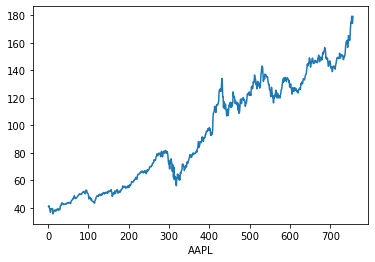

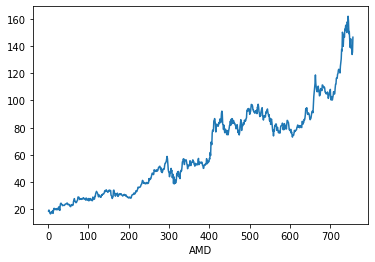

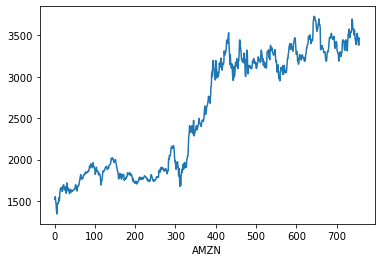

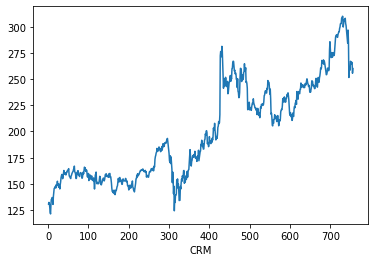

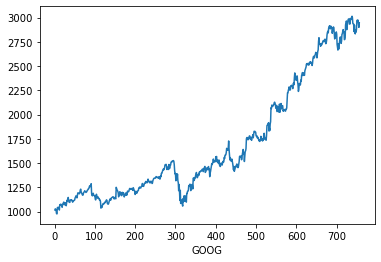

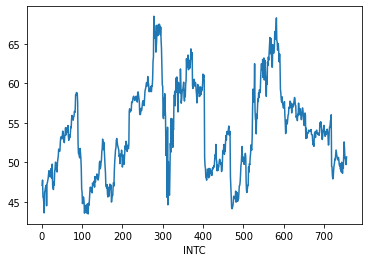

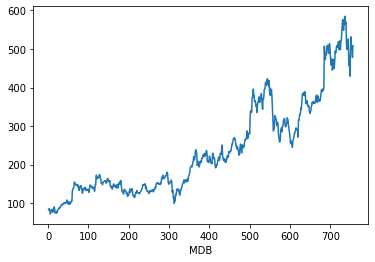

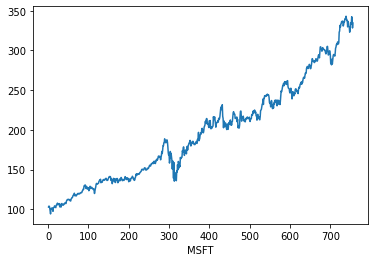

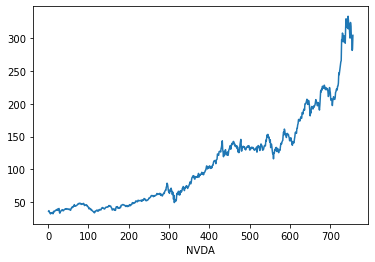

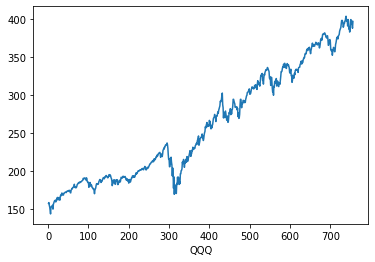

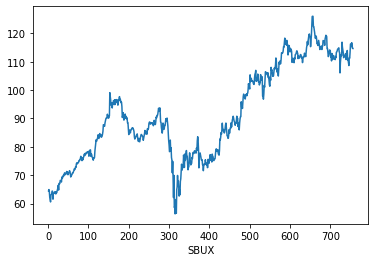

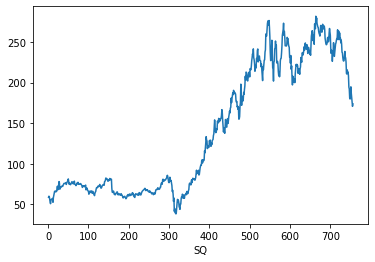

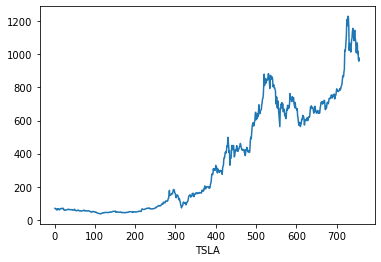

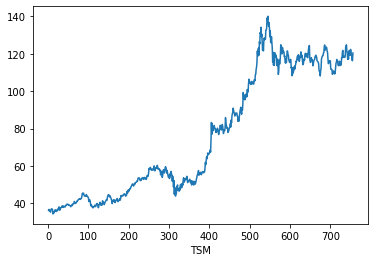

In [406]:
for i in lista:
    x = df['Index']
    y = df[str(i)]
    plt.plot(x, y)

    plt.xlabel(i)
    plt.show()

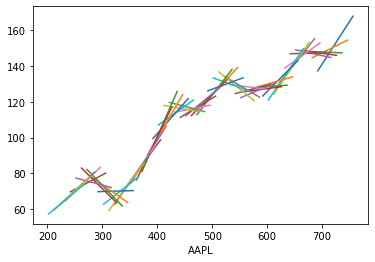

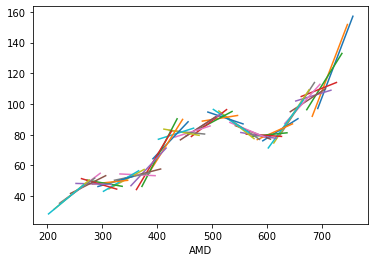

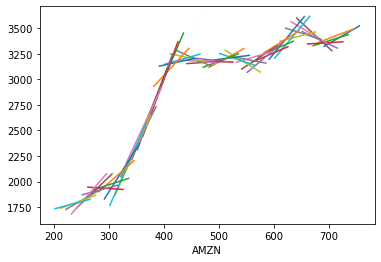

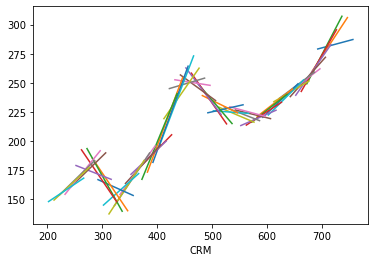

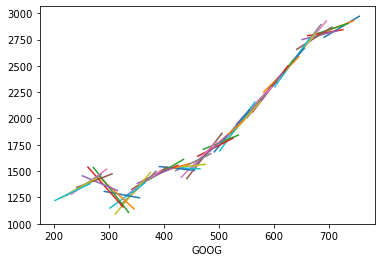

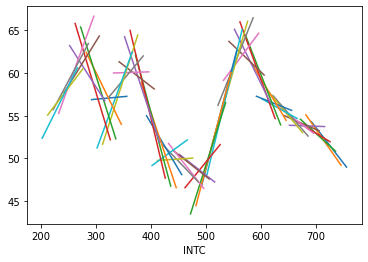

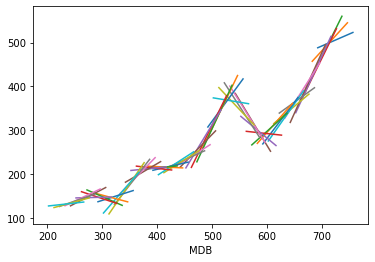

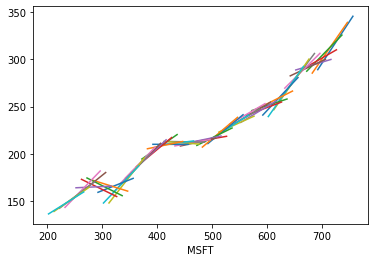

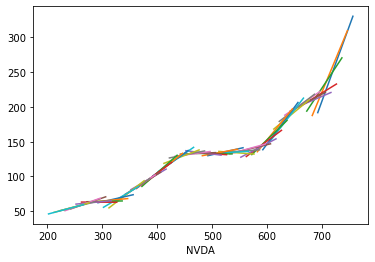

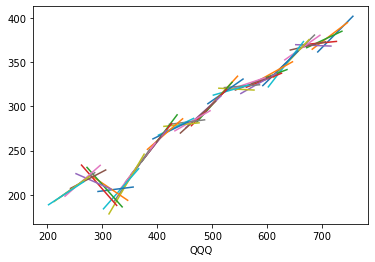

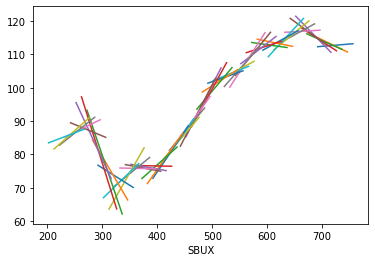

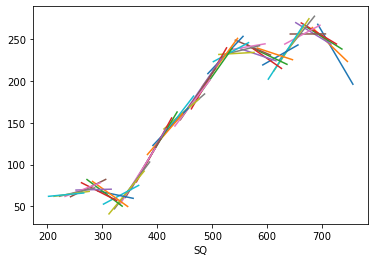

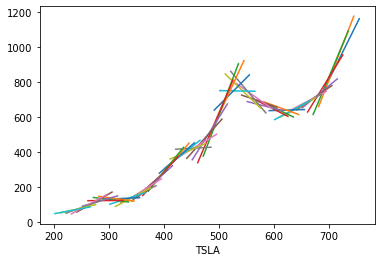

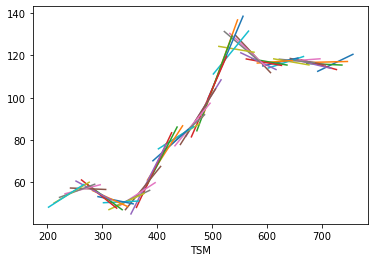

In [407]:
# plot only trendlines, bi-weekly, each line representing 1 year of data
# if the movement is too stable, these graphs won't be useable

for j in lista:
    for i in range(len(dataframes)):
        x = dataframes['data' + str(i)]['Index']
        y = dataframes['data' + str(i)][str(j)]

        m, b = np.polyfit(x, y, 1)
        plt.plot(x, m*x + b)

    plt.xlabel(j)
    plt.show()

In [408]:
# create pred and pred/close list for each of the 50 dataframes
# may take 30+ seconds to run

k = len(dataframes)

for j in lista:
    for e in range(k):
        nlist = []
        ylist = []
        y = dataframes['data' + str(e)][str(j)]

        for i in range(1,len(dataframes['data0'])+1): # create pred
            x = range(1,roll_days+1) # range must be 1-roll_days, not the auto implied 0-(roll_days-1)
            m, b = np.polyfit(x, y, 1)
            d = m*i+b
            nlist.append(d)

        dataframes['data' + str(e)][str(j) + ' pred'] = nlist

        for i in range(1,len(dataframes['data0'])+1): # create pred/close
            d = (dataframes['data' + str(e)][str(j) + ' pred'].iloc[i-1])/(dataframes['data' + str(e)][str(j)].iloc[i-1])
            ylist.append(d)

        dataframes['data' + str(e)][str(j) + ' pred/close'] = ylist

dataframes['data0']

<ipython-input-408-d64cdb0e1516>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes['data' + str(e)][str(j) + ' pred'] = nlist
<ipython-input-408-d64cdb0e1516>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframes['data' + str(e)][str(j) + ' pred/close'] = ylist


,AAPL,AMD,AMZN,CRM,GOOG,INTC,MDB,MSFT,NVDA,QQQ,...,QQQ pred,QQQ pred/close,SBUX pred,SBUX pred/close,SQ pred,SQ pred/close,TSLA pred,TSLA pred/close,TSM pred,TSM pred/close
Date,,,,,,,,,,,,,,,,,,,,,
2021-09-15,149.029999,105.599998,3475.790039,256.160004,2904.120117,55.119999,503.500000,304.820007,223.410004,378.049988,...,361.319020,0.955744,112.290238,0.979503,267.842837,1.076539,757.525650,1.002243,112.466392,0.925649
2021-09-16,148.789993,106.220001,3488.239990,260.359985,2887.469971,54.830002,509.649994,305.220001,222.419998,378.309998,...,361.948796,0.956752,112.304038,0.979367,266.722393,1.045601,763.839901,1.009049,112.591639,0.932127
2021-09-17,146.059998,103.879997,3462.520020,260.529999,2829.270020,54.259998,506.989990,299.869995,219.000000,373.829987,...,362.578571,0.969902,112.317838,0.990370,265.601949,1.038359,770.154152,1.014041,112.716887,0.957256
2021-09-20,142.940002,101.550003,3355.729980,258.220001,2780.340088,52.980000,489.269989,294.299988,211.130005,365.700012,...,363.208347,0.993187,112.331639,1.004576,264.481504,1.056954,776.468403,1.063408,112.842134,0.983802
2021-09-21,143.429993,102.820000,3343.629883,257.970001,2792.929932,52.869999,488.640015,294.799988,212.460007,366.149994,...,363.838123,0.993686,112.345439,1.001118,263.361060,1.047995,782.782655,1.058701,112.967381,0.982667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-09,174.559998,138.100006,3483.419922,264.320007,2962.120117,50.480000,513.280029,333.100006,304.899994,393.730011,...,399.105571,1.013653,113.118254,0.980652,200.616171,1.074250,1136.380728,1.132079,119.981234,1.004027
2021-12-10,179.449997,138.550003,3444.239990,266.029999,2973.500000,50.590000,507.730011,342.540009,301.980011,398.010010,...,399.735346,1.004335,113.132054,0.969177,199.495726,1.100241,1142.694979,1.123561,120.106482,1.008197
2021-12-13,175.740005,133.800003,3391.350098,265.760010,2934.090088,50.000000,494.929993,339.399994,281.609985,392.260010,...,400.365122,1.020663,113.145855,0.979109,198.375282,1.130730,1149.009231,1.188946,120.231729,1.032741


In [409]:
# pull the last 'close' and pred/close' from each dataframe in dataframes and make a new dataframe out of it
# each row is the last close price in a 1-year period and the final pred/close derived from a 1-year trendline
# the rows have a 50 week overlap and are separated by 2 weeks

df = pd.DataFrame()
add_index = np.arange(1,len(dataframes)+1)
df['Index'] = add_index

for j in lista:
    nlist = []
    ylist = []
    zlist = []
    k = len(dataframes['data0'])

    for e in reversed(range(len(dataframes))):
        nlist.append(round(dataframes['data' + str(e)][str(j) + ' pred/close'].iloc[k-1],4))
        ylist.append(round(dataframes['data' + str(e)][str(j)].iloc[k-1],4))
        zlist.append(round(dataframes['data' + str(e)][str(j) + ' pred'].iloc[k-1],2))

    df[str(j)] = pd.DataFrame(ylist)
    df[str(j) + ' pred'] = pd.DataFrame(zlist)
    df[str(j) + ' pred/close'] = pd.DataFrame(nlist)

df.tail(10)

,Index,AAPL,AAPL pred,AAPL pred/close,AMD,AMD pred,AMD pred/close,AMZN,AMZN pred,AMZN pred/close,...,SBUX pred/close,SQ,SQ pred,SQ pred/close,TSLA,TSLA pred,TSLA pred/close,TSM,TSM pred,TSM pred/close
40,41,146.09,149.83,1.0256,107.58,102.85,0.9561,3341.8701,3617.03,1.0823,...,1.0239,279.73,267.02,0.9546,713.76,692.67,0.9705,118.22,119.45,1.0104
41,42,149.71,153.28,1.0238,108.77,109.15,1.0035,3265.8701,3463.42,1.0605,...,1.0423,270.44,274.50,1.0150,706.30,708.50,1.0031,110.96,115.48,1.0407
42,43,156.69,155.35,0.9915,109.15,113.96,1.0441,3509.2900,3391.35,0.9664,...,1.0288,265.83,277.48,1.0438,752.92,729.86,0.9694,124.70,116.60,0.9351
43,44,143.43,152.95,1.0664,102.82,112.84,1.0974,3343.6299,3356.95,1.0040,...,1.0447,251.30,266.72,1.0614,739.38,746.53,1.0097,114.96,118.37,1.0297
44,45,141.11,147.43,1.0448,101.81,109.91,1.0796,3221.0000,3279.67,1.0182,...,1.0201,235.98,256.33,1.0862,780.59,779.24,0.9983,109.26,115.52,1.0573
45,46,148.76,144.84,0.9736,116.33,108.96,0.9367,3444.1499,3305.38,0.9597,...,0.9746,254.41,244.09,0.9594,864.27,817.71,0.9461,116.96,113.87,0.9736
46,47,150.02,146.06,0.9736,127.63,114.00,0.8932,3312.7500,3366.94,1.0164,...,0.9966,249.01,244.28,0.9810,1172.00,954.90,0.8148,114.11,113.29,0.9928
47,48,151.00,147.45,0.9765,152.45,132.92,0.8719,3540.7000,3437.08,0.9707,...,0.9935,238.47,238.24,0.9990,1054.73,1092.02,1.0354,118.08,115.42,0.9775
48,49,164.77,154.58,0.9382,149.11,151.75,1.0177,3443.7200,3493.04,1.0143,...,1.0189,194.50,223.39,1.1486,1095.00,1175.55,1.0736,120.63,117.10,0.9707
49,50,179.30,167.96,0.9368,146.50,157.12,1.0725,3466.3000,3522.59,1.0162,...,0.9869,173.80,196.13,1.1285,975.99,1161.64,1.1902,120.40,120.48,1.0007


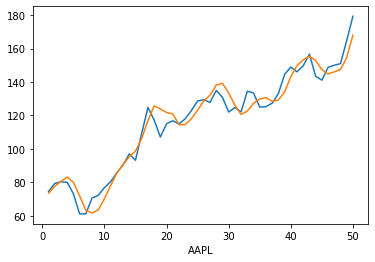

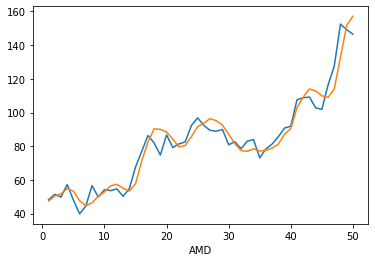

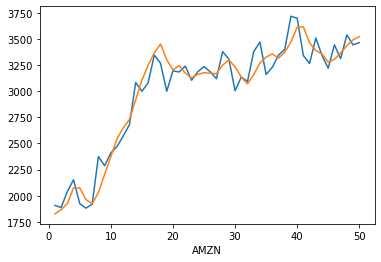

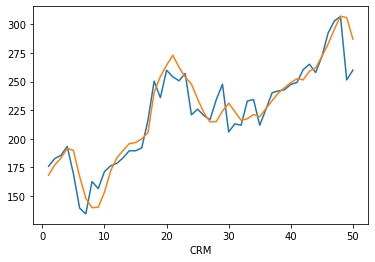

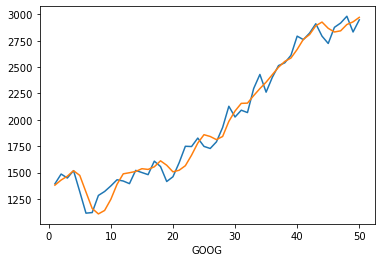

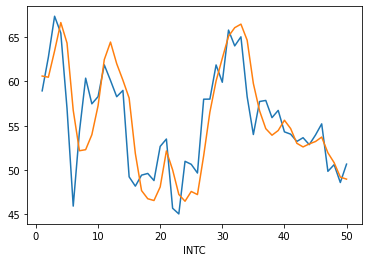

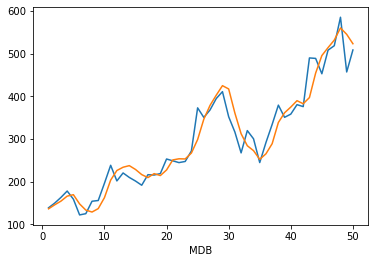

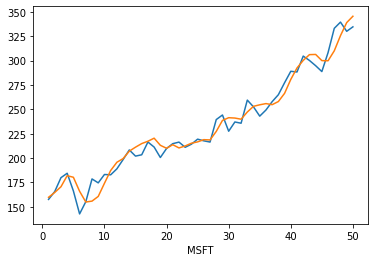

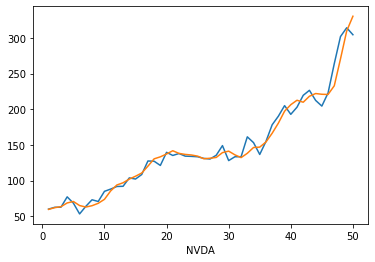

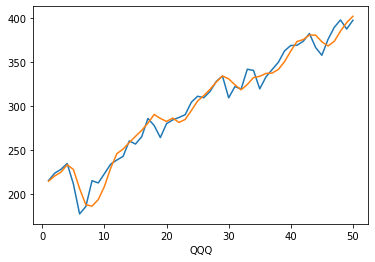

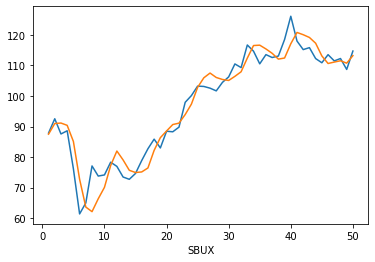

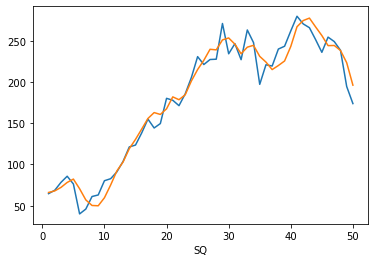

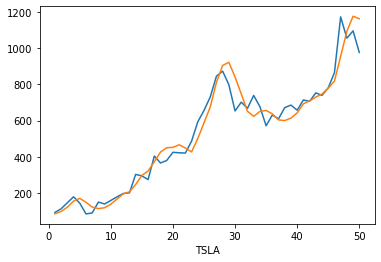

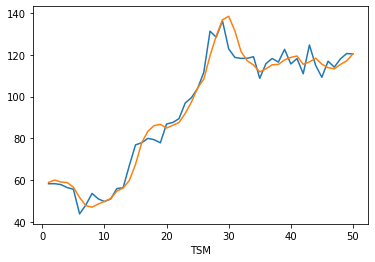

In [410]:
# plot for each stock the close price and the prediction price
# close (blue) below prediction (orange) = stock is underperforming

for i in lista:
    x = df['Index']
    y = df[str(i)]
    plt.plot(x, y)

    x = df['Index']
    y = df[str(i) + ' pred']
    plt.plot(x, y)

    plt.xlabel(i)
    plt.show()

#### At this point, the foundation is set and strategies can be created and tested.

In [411]:
# determine the weeks where pred/close is >1 and therefore they are better weeks to buy in
# steady stocks could be at about 50/50 but stocks exponentially rising could have close to 0 pred/close > 1

for j in lista:
    nlist = []
    for i in range(len(df)):
        if df[str(j) + ' pred/close'].iloc[i] >= 1:
            nlist.append(1)
        else:
            nlist.append(0)

    df[str(j) + ' >1'] = nlist

df.tail(10)

,Index,AAPL,AAPL pred,AAPL pred/close,AMD,AMD pred,AMD pred/close,AMZN,AMZN pred,AMZN pred/close,...,GOOG >1,INTC >1,MDB >1,MSFT >1,NVDA >1,QQQ >1,SBUX >1,SQ >1,TSLA >1,TSM >1
40,41,146.09,149.83,1.0256,107.58,102.85,0.9561,3341.8701,3617.03,1.0823,...,1,1,1,1,1,1,1,0,0,1
41,42,149.71,153.28,1.0238,108.77,109.15,1.0035,3265.8701,3463.42,1.0605,...,0,0,1,0,0,1,1,1,1,1
42,43,156.69,155.35,0.9915,109.15,113.96,1.0441,3509.2900,3391.35,0.9664,...,0,0,0,1,0,0,1,1,0,0
43,44,143.43,152.95,1.0664,102.82,112.84,1.0974,3343.6299,3356.95,1.0040,...,1,1,0,1,1,1,1,1,1,1
44,45,141.11,147.43,1.0448,101.81,109.91,1.0796,3221.0000,3279.67,1.0182,...,1,0,1,1,1,1,1,1,0,1
45,46,148.76,144.84,0.9736,116.33,108.96,0.9367,3444.1499,3305.38,0.9597,...,0,0,1,0,0,0,0,0,0,0
46,47,150.02,146.06,0.9736,127.63,114.00,0.8932,3312.7500,3366.94,1.0164,...,0,1,1,0,0,0,0,0,0,0
47,48,151.00,147.45,0.9765,152.45,132.92,0.8719,3540.7000,3437.08,0.9707,...,0,1,0,0,0,0,0,0,1,0
48,49,164.77,154.58,0.9382,149.11,151.75,1.0177,3443.7200,3493.04,1.0143,...,1,1,1,1,0,1,1,1,1,0
49,50,179.30,167.96,0.9368,146.50,157.12,1.0725,3466.3000,3522.59,1.0162,...,1,0,1,1,1,1,0,1,1,1


In [412]:
# square the pred/close number as a more extreme option for calculations

for j in lista:
    df[str(j) +' pred/close2'] = round(df[str(j) +' pred/close']**2,4) # make the value differences a little more pronounced

df.tail(10)

,Index,AAPL,AAPL pred,AAPL pred/close,AMD,AMD pred,AMD pred/close,AMZN,AMZN pred,AMZN pred/close,...,GOOG pred/close2,INTC pred/close2,MDB pred/close2,MSFT pred/close2,NVDA pred/close2,QQQ pred/close2,SBUX pred/close2,SQ pred/close2,TSLA pred/close2,TSM pred/close2
40,41,146.09,149.83,1.0256,107.58,102.85,0.9561,3341.8701,3617.03,1.0823,...,1.0020,1.0233,1.0492,1.0288,1.0983,1.0231,1.0484,0.9113,0.9419,1.0209
41,42,149.71,153.28,1.0238,108.77,109.15,1.0035,3265.8701,3463.42,1.0605,...,0.9900,0.9920,1.0363,0.9710,0.9139,1.0104,1.0864,1.0302,1.0062,1.0831
42,43,156.69,155.35,0.9915,109.15,113.96,1.0441,3509.2900,3391.35,0.9664,...,0.9870,0.9616,0.6569,1.0400,0.9278,0.9910,1.0584,1.0895,0.9397,0.8744
43,44,143.43,152.95,1.0664,102.82,112.84,1.0974,3343.6299,3356.95,1.0040,...,1.0979,1.0028,0.8642,1.0797,1.0929,1.0781,1.0914,1.1266,1.0195,1.0603
44,45,141.11,147.43,1.0448,101.81,109.91,1.0796,3221.0000,3279.67,1.0182,...,1.1082,0.9732,1.1968,1.0795,1.1686,1.0876,1.0406,1.1798,0.9966,1.1179
45,46,148.76,144.84,0.9736,116.33,108.96,0.9367,3444.1499,3305.38,0.9597,...,0.9694,0.9469,1.0233,0.9463,0.9813,0.9604,0.9498,0.9204,0.8951,0.9479
46,47,150.02,146.06,0.9736,127.63,114.00,0.8932,3312.7500,3366.94,1.0164,...,0.9500,1.0853,1.0512,0.8662,0.7788,0.9203,0.9932,0.9624,0.6639,0.9857
47,48,151.00,147.45,0.9765,152.45,132.92,0.8719,3540.7000,3437.08,0.9707,...,0.9479,1.0090,0.9160,0.9199,0.8030,0.9372,0.9870,0.9980,1.0721,0.9555
48,49,164.77,154.58,0.9382,149.11,151.75,1.0177,3443.7200,3493.04,1.0143,...,1.0689,1.0252,1.4230,1.0549,0.9714,1.0382,1.0382,1.3193,1.1526,0.9423
49,50,179.30,167.96,0.9368,146.50,157.12,1.0725,3466.3000,3522.59,1.0162,...,1.0161,0.9345,1.0582,1.0661,1.1777,1.0231,0.9740,1.2735,1.4166,1.0014


In [413]:
# Create all of the strategies to test 

for j in lista:
    
# baseline - buy in $10 bi-weekly no matter what - baseline
    df[str(j) +' baseline'] = 0
    df[str(j) +' baseline_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' baseline'].iloc[i] = biwkly_contrib
        df[str(j) +' baseline_stk'].iloc[i] = round(df[str(j) +' baseline'].iloc[i]/df[str(j)].iloc[i],4)
        v -= biwkly_contrib
        if v < biwkly_contrib:
            break

# opt1 - buy in every other week but proportionally to the pred/close
    df[str(j) +' opt1'] = 0
    df[str(j) +' opt1_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' opt1'].iloc[i] = biwkly_contrib*df[str(j) +' pred/close'].iloc[i]
        df[str(j) +' opt1_stk'].iloc[i] = round(df[str(j) +' opt1'].iloc[i]/df[str(j)].iloc[i],4)
        v -= biwkly_contrib*df[str(j) +' pred/close'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < biwkly_contrib*df[str(j) +' pred/close'].iloc[t]:
            break

# opt2 - buy in every other week but proportionally to the square of pred/close
    df[str(j) +' opt2'] = 0
    df[str(j) +' opt2_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' opt2'].iloc[i] = biwkly_contrib*df[str(j) +' pred/close2'].iloc[i]
        df[str(j) +' opt2_stk'].iloc[i] = round(df[str(j) +' opt2'].iloc[i]/df[str(j)].iloc[i],4)
        v -= biwkly_contrib*df[str(j) +' pred/close2'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < biwkly_contrib*df[str(j) +' pred/close2'].iloc[t]:
            break

# opt3 - buy in every other week. 0 on days <1 and twice the normal bi-weekly contribution on days >= 1
    df[str(j) +' opt3'] = 0
    df[str(j) +' opt3_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' opt3'].iloc[i] = biwkly_contrib*2*df[str(j) +' >1'].iloc[i] 
        df[str(j) +' opt3_stk'].iloc[i] = round(df[str(j) +' opt3'].iloc[i]/df[str(j)].iloc[i],4)
        v -= biwkly_contrib*2*df[str(j) +' >1'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < biwkly_contrib*2*df[str(j) +' >1'].iloc[t]:
            break

# opt4 - buy in every other week but proportionally to the inverse of pred/close
# This is more of a validation and will ideally return negative compared to baseline
    df[str(j) +' opt4'] = 0
    df[str(j) +' opt4_stk'] = 0
    v = invest
    for i in range(len(df)):
        df[str(j) +' opt4'].iloc[i] = round(biwkly_contrib/df[str(j) +' pred/close'].iloc[i],4)
        df[str(j) +' opt4_stk'].iloc[i] = round(df[str(j) +' opt4'].iloc[i]/df[str(j)].iloc[i],4)
        v -= biwkly_contrib/df[str(j) +' pred/close'].iloc[i]
        if i == (len(df)-1):
            t = i
        else:
            t = i+1
        if v < biwkly_contrib/df[str(j) +' pred/close'].iloc[t]:
            break

df.tail(10)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Index,AAPL,AAPL pred,AAPL pred/close,AMD,AMD pred,AMD pred/close,AMZN,AMZN pred,AMZN pred/close,...,TSM baseline,TSM baseline_stk,TSM opt1,TSM opt1_stk,TSM opt2,TSM opt2_stk,TSM opt3,TSM opt3_stk,TSM opt4,TSM opt4_stk
40,41,146.09,149.83,1.0256,107.58,102.85,0.9561,3341.8701,3617.03,1.0823,...,10,0.0846,10.104,0.0855,10.209,0.0864,20,0.1692,9.8971,0.0837
41,42,149.71,153.28,1.0238,108.77,109.15,1.0035,3265.8701,3463.42,1.0605,...,10,0.0901,10.407,0.0938,10.831,0.0976,20,0.1802,9.6089,0.0866
42,43,156.69,155.35,0.9915,109.15,113.96,1.0441,3509.2900,3391.35,0.9664,...,10,0.0802,9.351,0.0750,8.744,0.0701,0,0.0000,10.6940,0.0858
43,44,143.43,152.95,1.0664,102.82,112.84,1.0974,3343.6299,3356.95,1.0040,...,10,0.0870,10.297,0.0896,10.603,0.0922,20,0.1740,9.7116,0.0845
44,45,141.11,147.43,1.0448,101.81,109.91,1.0796,3221.0000,3279.67,1.0182,...,10,0.0915,10.573,0.0968,11.179,0.1023,20,0.1830,9.4581,0.0866
45,46,148.76,144.84,0.9736,116.33,108.96,0.9367,3444.1499,3305.38,0.9597,...,10,0.0855,9.736,0.0832,9.479,0.0810,0,0.0000,10.2712,0.0878
46,47,150.02,146.06,0.9736,127.63,114.00,0.8932,3312.7500,3366.94,1.0164,...,10,0.0876,9.928,0.0870,9.857,0.0864,0,0.0000,10.0725,0.0883
47,48,151.00,147.45,0.9765,152.45,132.92,0.8719,3540.7000,3437.08,0.9707,...,10,0.0847,9.775,0.0828,9.555,0.0809,0,0.0000,10.2302,0.0866
48,49,164.77,154.58,0.9382,149.11,151.75,1.0177,3443.7200,3493.04,1.0143,...,10,0.0829,9.707,0.0805,9.423,0.0781,0,0.0000,10.3018,0.0854
49,50,179.30,167.96,0.9368,146.50,157.12,1.0725,3466.3000,3522.59,1.0162,...,10,0.0831,0.000,0.0000,0.000,0.0000,20,0.1661,0.0000,0.0000


In [414]:
print('baseline - contribute 10 every other week')
print('opt1 - buy in every other week proportional to the pred/close variable')
print('opt2 - buy in every other week proportional to the square of pred/close variable')
print('opt3 - contribute twice the normal bi-weekly contrib only on the weeks where pred/close is >=1')
print('opt4 - buy in every other week inversely proportional to the pred/close variable')

df_bought_in = pd.DataFrame()
df_profit = pd.DataFrame()
df_diff = pd.DataFrame()

for j in lista:
    d = {'name': [str(j) +' baseline', str(j) +' op1', str(j) +' op2', str(j) +' op3', str(j) +' op4']
         ,'bought_in': [
             round(sum(df[str(j) +' baseline']),2),
             round(sum(df[str(j) +' opt1']),2), 
             round(sum(df[str(j) +' opt2']),2), 
             round(sum(df[str(j) +' opt3']),2),
             round(sum(df[str(j) +' opt4']),2)]
         ,'stocks_held': [
             round(sum(df[str(j) +' baseline_stk']),4), 
             round(sum(df[str(j) +' opt1_stk']),4), 
             round(sum(df[str(j) +' opt2_stk']),4), 
             round(sum(df[str(j) +' opt3_stk']),4), 
             round(sum(df[str(j) +' opt4_stk']),4)]
#          ,'cost_per_stock': [
#              sum(df[str(j) +' baseline'])/sum(df[str(j) +' baseline_stk']), 
#              sum(df[str(j) +' opt1'])/sum(df[str(j) +' opt1_stk']), 
#              sum(df[str(j) +' opt2'])/sum(df[str(j) +' opt2_stk']), 
#              sum(df[str(j) +' opt3'])/sum(df[str(j) +' opt3_stk']), 
#             sum(df[str(j) +' opt4'])/sum(df[str(j) +' opt4_stk'])]
         ,'profit': [
             round((sum(df[str(j) +' baseline_stk']) * df[str(j)].iloc[49]) - sum(df[str(j) +' baseline']),2),
             round((sum(df[str(j) +' opt1_stk']) * df[str(j)].iloc[49]) - sum(df[str(j) +' opt1']),2), 
             round((sum(df[str(j) +' opt2_stk']) * df[str(j)].iloc[49]) - sum(df[str(j) +' opt2']),2), 
             round((sum(df[str(j) +' opt3_stk']) * df[str(j)].iloc[49]) - sum(df[str(j) +' opt3']),2), 
             round((sum(df[str(j) +' opt4_stk']) * df[str(j)].iloc[49]) - sum(df[str(j) +' opt4']),2)]
        }

    df2 = pd.DataFrame(data=d)

    df2['diff'] = 0
    df2['diff'].iloc[1] = round(df2['profit'].iloc[1]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[2] = round(df2['profit'].iloc[2]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[3] = round(df2['profit'].iloc[3]-df2['profit'].iloc[0],2)
    df2['diff'].iloc[4] = round(df2['profit'].iloc[4]-df2['profit'].iloc[0],2)

    df2['%_diff'] = round((df2['diff']/df2['profit'])*100,2)

    print('')
    print(df2)
    
    df_bought_in[str(j) + ' bought_in'] = df2['bought_in']
    df_profit[str(j) + ' profit'] = df2['profit']
    df_diff[str(j) + ' diff'] = df2['diff']

baseline - contribute 10 every other week
opt1 - buy in every other week proportional to the pred/close variable
opt2 - buy in every other week proportional to the square of pred/close variable
opt3 - contribute twice the normal bi-weekly contrib only on the weeks where pred/close is >=1
opt4 - buy in every other week inversely proportional to the pred/close variable

            name  bought_in  stocks_held  profit  diff  %_diff
0  AAPL baseline     500.00       4.6026  325.25  0.00    0.00
1       AAPL op1     491.47       4.5677  327.52  2.27    0.69
2       AAPL op2     494.74       4.6088  331.62  6.37    1.92
3       AAPL op3     460.00       4.3729  324.06 -1.19   -0.37
4       AAPL op4     490.28       4.5454  324.71 -0.54   -0.17

           name  bought_in  stocks_held  profit   diff  %_diff
0  AMD baseline     500.00       6.7366  486.91   0.00    0.00
1       AMD op1     491.10       6.7252  494.14   7.23    1.46
2       AMD op2     495.05       6.8251  504.83  17.92    3.5

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [415]:
# how much was ivested
# no amount should be above the previously set 'invest' amount
# row 0 = baselines. Rows 1-4 = options 1-4
df_bought_in

,AAPL bought_in,AMD bought_in,AMZN bought_in,CRM bought_in,GOOG bought_in,INTC bought_in,MDB bought_in,MSFT bought_in,NVDA bought_in,QQQ bought_in,SBUX bought_in,SQ bought_in,TSLA bought_in,TSM bought_in
0,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00
1,491.47,491.10,490.36,494.41,490.94,492.06,490.66,491.17,498.37,490.66,491.31,496.39,492.82,490.44
2,494.74,495.05,491.74,486.46,493.58,496.51,496.49,493.36,498.95,492.30,494.16,499.23,497.40,492.48
3,460.00,480.00,500.00,500.00,500.00,460.00,500.00,500.00,460.00,480.00,500.00,500.00,440.00,500.00
4,490.28,491.73,490.66,496.95,490.77,490.20,494.60,499.54,494.64,490.31,490.27,499.81,497.93,491.14


In [416]:
# profits made above/below the investment
# row 0 = baselines. Rows 1-4 = options 1-4
df_profit

,AAPL profit,AMD profit,AMZN profit,CRM profit,GOOG profit,INTC profit,MDB profit,MSFT profit,NVDA profit,QQQ profit,SBUX profit,SQ profit,TSLA profit,TSM profit
0,325.25,486.91,98.98,107.06,312.00,-38.21,505.94,254.90,783.45,192.34,110.57,148.57,1069.98,219.92
1,327.52,494.14,98.91,109.11,314.58,-37.56,510.30,257.01,786.24,193.58,111.65,170.13,1136.20,221.48
2,331.62,504.83,100.65,111.48,319.60,-37.00,520.28,260.17,793.76,195.51,113.46,216.67,1290.23,224.13
3,324.06,507.20,102.79,123.86,338.53,-31.10,520.02,289.07,737.62,187.60,118.71,165.31,894.47,250.43
4,324.71,482.86,102.08,105.83,309.74,-38.94,507.48,253.42,784.88,191.83,110.26,142.17,1063.07,219.47


In [417]:
# profits made above/below the baseline profits
# row 0 = baselines. Rows 1-4 = options 1-4
df_diff[1:5]

,AAPL diff,AMD diff,AMZN diff,CRM diff,GOOG diff,INTC diff,MDB diff,MSFT diff,NVDA diff,QQQ diff,SBUX diff,SQ diff,TSLA diff,TSM diff
1,2.27,7.23,-0.07,2.05,2.58,0.65,4.36,2.11,2.79,1.24,1.08,21.56,66.22,1.56
2,6.37,17.92,1.67,4.42,7.60,1.21,14.34,5.27,10.31,3.17,2.89,68.10,220.25,4.21
3,-1.19,20.29,3.81,16.80,26.53,7.11,14.08,34.17,-45.83,-4.74,8.14,16.74,-175.51,30.51
4,-0.54,-4.05,3.10,-1.23,-2.26,-0.73,1.54,-1.48,1.43,-0.51,-0.31,-6.40,-6.91,-0.45


In [418]:
# Final summary calculations
# if you take chosen stocks and apply chosen investment strategies over the course of 2 years, 
# investing bi-weekly, you get these results:

print('Current date/time: ', datetime.datetime.now().strftime("%B %d, %Y %H:%M:%S"))
print('')

print('baseline - contribute 10 every other week')
print('opt1 - buy in every other week proportional to the pred/close variable')
print('opt2 - buy in every other week proportional to the square of pred/close variable')
print('opt3 - contribute twice the normal bi-weekly contrib only on the weeks where pred/close is >=1')
print('opt4 - buy in every other week inversely proportional to the pred/close variable')
print('')

# needed for when baseline total profit is negative
if sum(df_profit.iloc[0]) >= 0:
      x = 1
else:
      x = -1

if sum(df_diff.iloc[1]) >= 0:
      print(round(sum(df_diff.iloc[1]),2), 'opt1 profit over baseline.', 
            round(sum(df_profit.iloc[1]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[1]),2), 'investment.',
            round((sum(df_diff.iloc[1])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[1]),2), 'opt2 loss compared to baseline.', 
            round(sum(df_profit.iloc[1]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[1]),2), 'investment.',
            round((sum(df_diff.iloc[1])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[2]) >= 0:
      print(round(sum(df_diff.iloc[2]),2), 'opt2 profit over baseline.', 
            round(sum(df_profit.iloc[2]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[2]),2), 'investment.',
            round((sum(df_diff.iloc[2])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[2]),2), 'opt2 loss compared to baseline.', 
            round(sum(df_profit.iloc[2]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[2]),2), 'investment.',
            round((sum(df_diff.iloc[2])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[3]) >= 0:
      print(round(sum(df_diff.iloc[3]),2), 'opt3 profit over baseline.', 
            round(sum(df_profit.iloc[3]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[3]),2), 'investment.',
            round((sum(df_diff.iloc[3])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[3]),2), 'opt3 loss compared to baseline.', 
            round(sum(df_profit.iloc[3]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[3]),2), 'investment.',
            round((sum(df_diff.iloc[3])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')

if sum(df_diff.iloc[4]) >= 0:
      print(round(sum(df_diff.iloc[4]),2), 'opt4 profit over baseline.', 
            round(sum(df_profit.iloc[4]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[4]),2), 'investment.',
            round((sum(df_diff.iloc[4])/sum(df_profit.iloc[0]))*100,2)*x, 'percent above baseline profit.')
else:
      print(round(sum(df_diff.iloc[4]),2), 'opt4 loss compared to baseline.', 
            round(sum(df_profit.iloc[4]),2), 'core profit on', 
            round(sum(df_bought_in.iloc[4]),2), 'investment.',
            round((sum(df_diff.iloc[4])/sum(df_profit.iloc[0]))*100,2)*x, 'percent below baseline profit.')


Current date/time:  December 15, 2021 17:48:10

baseline - contribute 10 every other week
opt1 - buy in every other week proportional to the pred/close variable
opt2 - buy in every other week proportional to the square of pred/close variable
opt3 - contribute twice the normal bi-weekly contrib only on the weeks where pred/close is >=1
opt4 - buy in every other week inversely proportional to the pred/close variable

115.63 opt1 profit over baseline. 4693.29 core profit on 6892.16 investment. 2.53 percent above baseline profit.
367.73 opt2 profit over baseline. 4945.39 core profit on 6922.45 investment. 8.03 percent above baseline profit.
-49.09 opt3 loss compared to baseline. 4528.57 core profit on 6780.0 investment. -1.07 percent below baseline profit.
-18.8 opt4 loss compared to baseline. 4558.86 core profit on 6908.83 investment. -0.41 percent below baseline profit.


In [419]:
print("Using one of the strategies, today's buy in values are listed.")

now = pd.DataFrame()
opts = ['opt1', 'opt2', 'opt3', 'opt4']
now['method'] = opts

for j in lista:
    nlist = []
    for i in range(1, len(opts)+1):
        if i == 1: 
            x = biwkly_contrib * df[str(j) + ' pred/close'].iloc[49]
        elif i == 2:
            x = biwkly_contrib * df[str(j) + ' pred/close2'].iloc[49]
        elif i == 3:
            x = biwkly_contrib * 2 * df[str(j) + ' >1'].iloc[49]
        elif i == 4: 
            x = biwkly_contrib / df[str(j) + ' pred/close'].iloc[49]
        else: -1
        nlist.append(round(x,2))
    now[str(j)] = nlist

now

Using one of the strategies, today's buy in values are listed.


,method,AAPL,AMD,AMZN,CRM,GOOG,INTC,MDB,MSFT,NVDA,QQQ,SBUX,SQ,TSLA,TSM
0,opt1,9.37,10.72,10.16,11.04,10.08,9.67,10.29,10.32,10.85,10.12,9.87,11.28,11.90,10.01
1,opt2,8.78,11.50,10.33,12.20,10.16,9.35,10.58,10.66,11.78,10.23,9.74,12.74,14.17,10.01
2,opt3,0.00,20.00,20.00,20.00,20.00,0.00,20.00,20.00,20.00,20.00,0.00,20.00,20.00,20.00
3,opt4,10.67,9.32,9.84,9.05,9.92,10.34,9.72,9.69,9.21,9.89,10.13,8.86,8.40,9.99


#### "Final" notes

Stocks going up parabolically will almost never be above 1, so I can't simply not buy in when pred/close is not above 1. GOOG is like this as of 9/3/2021. This kind of stock will also produce worse than baseline profits for opt1 and opt2 because they won't be investing the full 500 over the course of the investment period. Option 3 is not viable.

Stocks in a big S-curve, flat ~ rise ~ flat, will only have a pred/close above 1 on the latter half of the year, so again, I can't contribute nothing. TSM and TSLA are like this as of 9/3/2021. Option 3 is not viable.

Options 1 and 2 seem to do well on stocks with lots of variation but loses on stocks seeing exponential growth. Missing out on a stock growing exponentially will surely wipe out all gains seen elsewhere. There may be some merit to opt4, the inverse method, but the baseline probably remains the best method if a single method is picked, and based only on daily closing values, for across the board investing.

#### Round 2 running notes - 12/15/2021
rolling 1 quarter has already shown to be better than at least 1 year or 1 month<br>
1 quarter instead of my original hypothesis of 1 year seems to be much more promising<br>
opt2 focus<br>
excluded MDB due to shorter stock lifespan<b>

Current run, 3 year period ending 12/15/2021:<br>
Stocks: 'AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'<br>
Dates '2018-12-15' - '2021-12-15'<br>
Rolling: 65 days (~1 quarter)<br>
353.39 opt2 profit over baseline. 4425.11 core profit on 6425.96 investment. 8.68 percent above baseline profit.<br>
TSLA represents most of the gains over baseline, but no individual stock did worse than baseline.<br>

Worst case end run ending on the worst part of the COVID nosedive:<br>
Stocks: 'AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'<br>
Dates '2017-03-20' - '2020-03-20'<br>
Rolling: 65 days (~1 quarter)<br>
19.21 opt2 profit over baseline. 489.81 core profit on 6408.78 investment. 4.08 percent above baseline profit.<br>
GOOG and SBUX were worse than baseline, but not more than $1 different. Good stability<br>

Best case end run ending right before the COVID drop:<br>
Stocks: 'AAPL', 'AMD', 'AMZN', 'CRM', 'GOOG', 'INTC', 'MSFT', 'NVDA', 'QQQ', 'SBUX', 'SQ', 'TSLA', 'TSM'<br>
Dates '2017-02-14' - '2020-02-14'<br>
Rolling: 65 days (~1 quarter)<br>
18.16 opt2 profit over baseline. 3576.39 core profit on 6445.56 investment. 0.51 percent above baseline profit.<br>
TSLA has 18.40 in gains over baseline, the rest were almost a wash<br>
